<a href="https://colab.research.google.com/github/aman-welzin/credzin/blob/main/pycode/src/rags/recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U langchain langchain-community langchain_experimental gradio pymupdf python-docx ollama langchain-huggingface langchain-neo4j lxml-html-clean pillow langgraph yfiles_jupyter_graphs neo4j langchain-neo4j langchain-ollama

# Install Ollama and CUDA drivers
import os
!nvidia-smi
!curl https://ollama.ai/install.sh | sh
!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get update && sudo apt-get install -y cuda-drivers
# Set LD_LIBRARY_PATH so the system NVIDIA library
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

!nohup ollama serve &
!ollama ps
# !ollama pull mistral-small3.1
!ollama pull llama3.2
!ollama list

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.9/437.9 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import io, ast, re, os, uuid, urllib, json, operator
from datetime import datetime
import pandas as pd
from tqdm.notebook import tqdm
import pprint
from IPython import embed
import matplotlib.font_manager
import matplotlib as mpl
from yfiles_jupyter_graphs import GraphWidget
import codecs
import base64
import PIL
from PIL import Image, ImageFont, ImageDraw, ImageColor
import textwrap
from IPython.display import Image, display
from neo4j import GraphDatabase
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.llms import Ollama
from langchain_core.prompts import ChatPromptTemplate
from langchain import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AIMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document
from langchain.docstore import InMemoryDocstore
from langchain.retrievers import ParentDocumentRetriever
from google.colab import userdata
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langchain.graphs import Neo4jGraph
from typing import List, Dict
from typing_extensions import TypedDict, Annotated
from langchain_experimental.graph_transformers import LLMGraphTransformer
from pydantic import BaseModel, Field
from langchain_community.vectorstores import Neo4jVector
from langchain_community.chat_models import ChatOllama




import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.environ["_URI"] = "neo4j+s://c64a3769.databases.neo4j.io"
os.environ["_USER"] = "neo4j"
os.environ["_PASSWORD"] = "mzP-L3pD-nGTc3hFpli2T7DsNbFA7jbp5bWHno1NSH4"

In [ ]:
def extract_card_names(query: str) -> list[str]:
    """
    Extracts card names from user query using LLM.
    Returns a plain list of card names.
    """



    llm = ChatOllama(
        base_url="http://localhost:11434",
        temperature=0,
        model="llama3.2",
    )

    def extract_list_from_string(text):
        match = re.search(r'\[.*\]', text, re.DOTALL)
        if match:
            try:
                return ast.literal_eval(match.group(0))
            except Exception as e:
                print("List parsing error:", e)
        return []

    prompt = f"""
You are an assistant that extracts **credit card names** from user queries.
Only return a **Python list of strings** — the card names mentioned in the query.

Example:
Input: Compare Axis Bank AURACredit Card with HDFC MoneyBack Card and SBI Premier Credit Card
Output: ["Axis Bank AURACredit Card", "HDFC MoneyBack Card", "SBI Premier Credit Card"]

Extract only the list of credit card names mentioned in the input.
Only return a Python list like: ["Card A", "Card B"]

Do not return code, explanation, or anything else.

Input: {query}
Output:
"""

    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        output = response.content.strip()
        print("LLM Output:", output)
        return extract_list_from_string(output)  # ✅ return list
    except Exception as e:
        print("LLM Exception:", e)
        return []


In [ ]:
def fetch_card_details(state: dict) -> dict:
    """
    fetch card details from Neo4j.
    Expects:
        - state["card_name"]: str
    Returns:
        - {"card_details": {query: ..., result: [...]}}
    """

    _URI      = os.getenv("_URI")
    _USER     = os.getenv("_USER")
    _PASSWORD = os.getenv("_PASSWORD")
    card_name = state.get("card_name")
    if not card_name:
        return {"card_details": {"query": "", "result": []}}

    cypher = """
    MATCH (b:Bank)-[:ISSUES]->(c:Card {name: $card_name})
    OPTIONAL MATCH (c)-[:HAS_FEATURE]->(f:Feature)
    OPTIONAL MATCH (c)-[:OFFERS_REWARD]->(r:Reward)
    OPTIONAL MATCH (c)-[:BELONGS_TO]->(cat:Category)
    RETURN
      c.name               AS CardName,
      c.card_type          AS CardType,
      c.usp                AS USP,
      c.joining_fee        AS JoiningFee,
      c.annual_fee         AS AnnualFee,
      c.annual_fee_waiver  AS AnnualFeeWaiver,
      c.interest_rate_pa   AS InterestRate,
      c.image_url          AS ImageURL,
      c.apply_now_link     AS ApplyNow,
      c.know_more_link     AS KnowMore,
      b.name               AS Issuer,
      collect(DISTINCT f.name)         AS Features,
      collect(DISTINCT r.description)  AS Rewards,
      collect(DISTINCT cat.name)       AS Categories
    """

    try:
        driver = GraphDatabase.driver(_URI, auth=(_USER, _PASSWORD))
        with driver.session() as session:
            result = session.run(cypher, {"card_name": card_name})
            rows = [record.data() for record in result]
        driver.close()

        return {
            "card_details": {
                "query": f"Show all the details of the credit card named {card_name}",
                "result": rows
            }
        }

    except Exception as e:
        return {
            "card_details": {
                "query": f"Failed to fetch details for {card_name}",
                "result": [],
                "error": str(e)
            }
        }


In [ ]:
def summarize_card(card_data: dict) -> dict:
    llm = ChatOllama(base_url="http://localhost:11434", temperature=0, model="llama3.2")

    if not card_data:
        return {"card_summary": "[ERROR] No valid card details provided."}

    prompt = f"""
You are a helpful assistant. Given the following raw credit card data in JSON-like format,
summarize the **key benefits**, **main features**, and **rewards** this card provides.

Also, mention any other notable or special details.

Card Data:
{card_data}

Now summarize clearly:
- Key Benefits:
- Key Features:
- Key Rewards:
- Other Notable Info:
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        return {"card_summary": response.content.strip()}
    except Exception as e:
        return {"card_summary": f"[ERROR] Failed to summarize due to: {e}"}


In [ ]:
def analyze_single_card_summary(state: dict) -> dict:
    """
    - Analyze one card summary
    - Extract reward/benefit categories
    - Identify two missing benefit categories for the user

    Expects:
        - 'card_summary': str
        - 'card_name': str

    Returns:
        - 'card_name': str
        - 'card_categories': list[str]
        - 'category_reasoning': str
        - 'missing_categories': list[str]
    """

    llm = ChatOllama(base_url="http://localhost:11434", temperature=0, model="llama3.2")

    card_name = state.get("card_name", "Unknown Card")
    summary = state.get("card_summary", "")

    prompt = f"""
You are a rewards analysis assistant.

STEP 1 – CARD ANALYSIS:
For the credit card summary below, extract and list the types of benefits or rewards it provides using these **standard** categories:
  welcome_points, milestone_rewards, bonus_points, cashback_offer,
  voucher_offer, travel_rewards, fuel_rewards, movie_rewards.

If a benefit doesn’t exactly match, infer a tag from this **extended** list:
  health benefits, movie discounts, shopping benefits, lounge access,
  fuel benefits, dining offers, electronic offers, customizable features, etc.

In the **Reason** section, for each category, quote the exact text from the summary that justifies it.

STEP 2 – FINDING MISSING CATEGORIES:
At the end, propose exactly two categories that the user does **not** already have — based on the current card’s offering.

Use this format:

---
**Card: {card_name}**
Categories: <comma-separated list>
Reason:
  - <Category1>: "<quote from summary>"
  - <Category2>: "<quote from summary>"

**Missing Categories:**
- <MissingCategory1>: <short justification>
- <MissingCategory2>: <short justification>

Card Summary:
{summary}
"""

    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        raw_output = response.content.strip()

        # Extract assigned categories
        match = re.search(r"Categories:\s*(.*)", raw_output)
        categories = []
        if match:
            categories_line = match.group(1)
            categories = [c.strip() for c in categories_line.split(",")]

        # Extract missing categories block
        missing = re.findall(r"\*\*Missing Categories:\*\*\s*- (.*?):", raw_output)
        missing_categories = [cat.strip() for cat in missing[:2]]  # max 2

        return {
            "card_name": card_name,
            "card_categories": categories,
            "category_reasoning": raw_output,
            "missing_categories": missing_categories
        }

    except Exception as e:
        return {
            "card_name": card_name,
            "card_categories": [],
            "missing_categories": [],
            "category_reasoning": f"[ERROR] Failed to analyze summary due to: {e}"
        }


In [ ]:
from langchain_neo4j import GraphCypherQAChain, Neo4jGraph
def query_cards_by_category(state: dict) -> dict:
    """
    - Takes 'category_query' string from state
    - Uses GraphCypherQAChain to return just the matching card names

    Returns:
        - 'matching_card_names': list[str]
    """

    # Neo4j connection setup (via env)
    _URI = os.getenv("_URI")
    _USER = os.getenv("_USER")
    _PASSWORD = os.getenv("_PASSWORD")
    _driver = GraphDatabase.driver(_URI, auth=(_USER, _PASSWORD))
    _graph = Neo4jGraph(
        url=_URI,
        username=_USER,
        password=_PASSWORD
    )

    schema = """
    (:Bank {name})
    (:Card {name, joining_fee, annual_fee, annual_fee_waiver, add_on_card_fee, interest_rate_pa, card_type, usp, image_url, apply_now_link, know_more_link})
    (:Feature {name})
    (:Reward {description})
    (:Category {name})
    Relationships:
    (Bank)-[:ISSUES]->(Card)
    (Card)-[:HAS_FEATURE]->(Feature)
    (Card)-[:OFFERS_REWARD]->(Reward)
    (Card)-[:BELONGS_TO]->(Category)
    """

    CYPHER_GENERATION_TEMPLATE = """Task: Generate Cypher statement to query a Neo4j database.
    Instructions:
    - Use only the provided relationship types and properties in the schema.
    - Use `toLower(...).contains("...")` when searching for values.
    - Prefer searching in Feature.name or Reward.description when the user asks for offers/discounts.
    Schema:
    {schema}

    Examples:
    # Which credit cards offer discounts on Decathlon?
    MATCH (c:Card)-[:HAS_FEATURE]->(f:Feature)
    WHERE toLower(f.name) CONTAINS "decathlon"
    RETURN c.name AS CardName

    # List credit cards that offer movie ticket benefits
    MATCH (c:Card)-[:HAS_FEATURE]->(f:Feature)
    WHERE toLower(f.name) CONTAINS "movie"
    RETURN c.name AS CardName

    The question is:
    {question}
    """

    cypher_prompt = PromptTemplate(
        input_variables=["schema", "question"],
        template=CYPHER_GENERATION_TEMPLATE
    )

    chain = GraphCypherQAChain.from_llm(
        llm=Ollama(model="llama3.2"),
        graph=_graph,
        verbose=True,
        cypher_prompt=cypher_prompt,
        return_direct=True,
        allow_dangerous_requests=True,
    )

    question = state.get("category_query", "")
    if not question:
        return {"matching_card_names": []}

    try:
        result = chain.invoke({"query": question})
        card_names = [row["CardName"] for row in result.get("result", [])]
        unique_card_names = list(dict.fromkeys(card_names))
        return {"matching_card_names": unique_card_names}
    except Exception as e:
        return {"matching_card_names": [], "error": str(e)}


In [ ]:
def recommend_cards_by_category(state: dict) -> dict:
    """
    - For each category and its list of candidate cards, choose the best card
    - Only recommend if the user lacks that category

    Expects:
        - 'user_cards': list[str]  (cards user already has)
        - 'cards_info': dict[str, list[dict]]  (category -> list of card detail dicts)

    Returns:
        - 'final_recommendations': dict[category -> recommendation text]
    """

    llm = ChatOllama(base_url="http://localhost:11434", temperature=0, model="llama3.2")

    user_cards = state.get("user_cards", [])
    cards_info = state.get("cards_info", {})

    def summarize_card_info(card_data: dict) -> str:
        prompt = f"""
You are a helpful assistant. Given the following raw credit card data in JSON-like format,
summarize the **key benefits**, **main features**, and **rewards** this card provides.

Also, mention any other notable or special details.

Card Data:
{card_data}

Now summarize clearly:
- Key Benefits:
- Key Features:
- Key Rewards:
- Other Notable Info:
"""
        resp = llm.invoke([HumanMessage(content=prompt)])
        return resp.content.strip()

    def choose_best_card(category: str,
                         summaries: dict[str, str],
                         user_cards: list[str]) -> str:
        existing = ", ".join(user_cards)
        bullet_list = "\n".join(
            f"{i+1}. **{name}**:\n{summaries[name]}"
            for i, name in enumerate(summaries)
        )

        prompt = f"""
        You are an expert financial advisor.

        The user currently holds these cards: {existing}.

        Below are summaries of credit cards that offer {category.replace('_',' ')}:

        {bullet_list}

        Task:
        1. Choose **exactly ONE** card from the list below as the best recommendation for {category.replace('_',' ')}.
        2. In your Reason, follow this structure:
          - Mention that the user does **not** currently have any {category.replace('_',' ')} rewards.
          - List the **specific rewards** from the recommended card that cover that category.
          - Call out **any additional facilities or benefits** the card provides beyond that category.
        3. Do **not** suggest multiple cards. Only recommend one.

        Answer format:

        - **Best Card**: <Card Name>
        - **Reason**: Based on your existing cards (<existing>), you lack any {category.replace('_',' ')}.
          The **<Best Card>** provides <list of category-specific rewards> and also offers <list of additional facilities>.
        """

        resp = llm.invoke([HumanMessage(content=prompt)])
        return resp.content.strip()

    final_recommendations = {}
    already_recommended = set()  # Track which cards have already been recommended

    for category, details_list in cards_info.items():
        card_summaries = {}
        for entry in details_list:
            if not entry or "result" not in entry or not entry["result"]:
                continue
            card_data = entry["result"][0]
            name = card_data.get("CardName", "Unknown")

            # Skip cards that have already been recommended for other categories
            # (but still include them if there are no other options)
            if name not in already_recommended or len(details_list) <= len(already_recommended):
                card_summaries[name] = summarize_card_info(card_data)

        if not card_summaries:
            final_recommendations[category] = f"No valid cards found for category: {category}"
            continue

        recommendation = choose_best_card(category, card_summaries, user_cards)
        final_recommendations[category] = recommendation

        # Extract the recommended card name from the recommendation text
        best_card_line = recommendation.split('\n')[0]
        if "Best Card" in best_card_line:
            card_name = best_card_line.split('Best Card')[1].strip(': **').rstrip('**')
            already_recommended.add(card_name)

    return {"final_recommendations": final_recommendations}

In [ ]:
class CardGraphState(TypedDict):
    user_query: str
    card_names: Annotated[List[str], operator.add]
    user_cards: List[str]
    card_details_list: Annotated[List[dict], operator.add]
    card_summaries: Annotated[Dict[str, str], operator.or_]
    card_categories: Annotated[List[str], operator.add]
    category_reasoning: str
    missing_categories: Annotated[List[str], operator.add]
    matching_card_names: Annotated[List[str], operator.add]
    cards_info: Dict[str, List[dict]]
    cards_by_category: Dict[str, List[str]]
    final_recommendations: Dict[str, str]
    recommended_cards_details_by_category: Dict[str, List[dict]]


In [ ]:
def extract_card_names_node(state: CardGraphState) -> dict:
    print("---EXTRACT CARD NAMES---")

    user_query = state["user_query"]
    card_names = extract_card_names(user_query)

    print(f"Extracted cards: {card_names}")
    return {
        "card_names": card_names,
        "user_cards": card_names
    }

def fetch_user_card_details_node(state: CardGraphState) -> dict:
    print("---FETCH USER CARD DETAILS---")

    card_names = state.get("card_names", [])
    card_details = []

    for name in card_names:
        result = fetch_card_details({"card_name": name})
        card_details.append(result.get("card_details", {}))

    return {
        "card_details_list": card_details
    }




def summarize_cards_node(state: CardGraphState) -> dict:
    print("---SUMMARIZE CARD DETAILS---")

    card_details_list = state.get("card_details_list", [])
    card_summaries = {}

    for card in card_details_list:
        if "result" in card and isinstance(card["result"], list) and card["result"]:
            card_data = card["result"][0]
            card_name = card_data.get("CardName", "Unknown")
            print(f"Summarizing: {card_name}")
            summary = summarize_card(card_data)
            card_summaries[card_name] = summary

    return {
        "card_summaries": card_summaries
    }

def analyze_all_card_summaries_node(state: CardGraphState) -> dict:
    print("---ANALYZE CARD SUMMARIES---")

    card_summaries = state.get("card_summaries", {})
    all_missing = []

    for card_name, summary in card_summaries.items():
        print(f"Analyzing summary for: {card_name}")
        result = analyze_single_card_summary({
            "card_name": card_name,
            "card_summary": summary
        })
        all_missing.extend(result.get("missing_categories", []))

    return {
        "missing_categories": list(set(all_missing))
    }

def query_all_missing_category_cards_node(state: CardGraphState) -> dict:
    print("---QUERY CARDS FOR MISSING CATEGORIES---")

    missing_categories = state.get("missing_categories", [])
    cards_by_category: Dict[str, List[str]] = {}

    for category in missing_categories:
        print(f"Querying cards for: {category}")
        query_state = {"category_query": category.replace("_", " ")}

        result = query_cards_by_category(query_state)
        names = result.get("matching_card_names", [])
        # dedupe
        unique = list(dict.fromkeys(names))

        cards_by_category[category] = unique
        print(f"  → Found: {unique}")

    return {
        "cards_by_category": cards_by_category
    }

def fetch_matched_card_details_node(state: CardGraphState) -> dict:
    print("---FETCH MATCHED CARD DETAILS (PER CATEGORY)---")

    cards_by_category = state.get("cards_by_category", {})
    details_by_category: Dict[str, List[dict]] = {}

    for category, card_names in cards_by_category.items():
        print(f"Fetching details for category '{category}': {card_names}")
        category_details = []
        for name in card_names:
            result = fetch_card_details({"card_name": name})
            detail = result.get("card_details", {})
            if detail:
                category_details.append(detail)
        details_by_category[category] = category_details

    return {
        "recommended_cards_details_by_category": details_by_category
    }




def recommend_cards_by_category_node(state: CardGraphState) -> dict:
    print("---RECOMMEND CARDS BY CATEGORY---")

    missing = state.get("missing_categories", [])
    user_cards = set(state.get("user_cards", []))
    all_cards_info = state.get("recommended_cards_details_by_category", {})

    if not all_cards_info or not user_cards:
        print(" Missing cards_info or user_cards in state.")
        return {"final_recommendations": {}}

    cards_info = {}

    for category in missing:
        raw_list = all_cards_info.get(category, [])
        filtered = []

        for card in raw_list:
            if "result" in card and card["result"]:
                card_name = card["result"][0].get("CardName", "")
                if card_name not in user_cards:
                    filtered.append(card)

        cards_info[category] = filtered
        print(f"[DEBUG] Cards for category '{category}': {[card['result'][0]['CardName'] for card in filtered]}")

    state["cards_info"] = cards_info
    result = recommend_cards_by_category(state)

    return {
        "final_recommendations": result.get("final_recommendations", {})
    }


In [ ]:
from langgraph.graph import StateGraph, END

# Initialize workflow with your custom state
workflow = StateGraph(CardGraphState)

# ─── Add Nodes ────────────────────────────────────────────────────────────────
workflow.add_node("ExtractCardNames", extract_card_names_node)
workflow.add_node("FetchCardDetails", fetch_user_card_details_node)
workflow.add_node("SummarizeCards", summarize_cards_node)
workflow.add_node("AnalyzeCardSummaries", analyze_all_card_summaries_node)
workflow.add_node("QueryMissingCategoryCards", query_all_missing_category_cards_node)
workflow.add_node("FetchMatchedCardDetails", fetch_matched_card_details_node)
workflow.add_node("RecommendCards", recommend_cards_by_category_node)

# ─── Define Entry Point ───────────────────────────────────────────────────────
workflow.set_entry_point("ExtractCardNames")

# ─── Define Edges ─────────────────────────────────────────────────────────────
workflow.add_edge("ExtractCardNames", "FetchCardDetails")
workflow.add_edge("FetchCardDetails", "SummarizeCards")
workflow.add_edge("SummarizeCards", "AnalyzeCardSummaries")
workflow.add_edge("AnalyzeCardSummaries", "QueryMissingCategoryCards")
workflow.add_edge("QueryMissingCategoryCards", "FetchMatchedCardDetails")
workflow.add_edge("FetchMatchedCardDetails", "RecommendCards")
workflow.add_edge("RecommendCards", END)

# ─── Compile ─────────────────────────────────────────────────────────────────
app = workflow.compile()


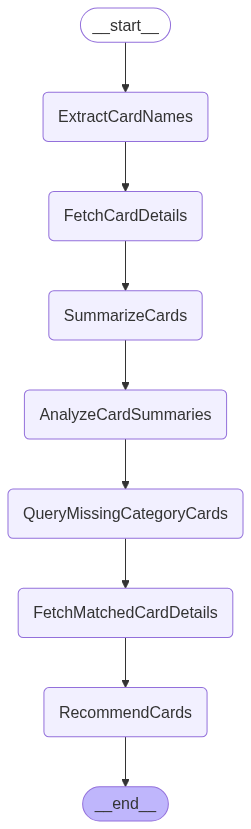

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from pprint import pprint

def run_pipeline(user_query: str):
    """
    Executes the credit card recommendation pipeline using just the user query.
    The user's card names are automatically extracted in the graph.
    """
    inputs = {
        "user_query": user_query
    }

    for output in app.stream(inputs):
        for node_name, value in output.items():
            print(f"\n🔹 Node '{node_name}':")
            pprint(value)


In [ ]:
run_pipeline({
    "user_query": "I have the SBI Card PRIME, Gold Card, and BYOC Credit Card. Suggest better options."
})


---EXTRACT CARD NAMES---
LLM Output: ["SBI Card PRIME", "Gold Card", "BYOC Credit Card"]
Extracted cards: ['SBI Card PRIME', 'Gold Card', 'BYOC Credit Card']

🔹 Node 'ExtractCardNames':
{'card_names': ['SBI Card PRIME', 'Gold Card', 'BYOC Credit Card'],
 'user_cards': ['SBI Card PRIME', 'Gold Card', 'BYOC Credit Card']}
---FETCH USER CARD DETAILS---

🔹 Node 'FetchCardDetails':
{'card_details_list': [{'query': 'Show all the details of the credit card '
                                 'named SBI Card PRIME',
                        'result': [{'AnnualFee': 0.0,
                                    'AnnualFeeWaiver': '',
                                    'ApplyNow': 'https://www.sbicard.com/en/eapply/eapplyform.page?path=personal/credit-cards/rewards/sbi-card-prime.dcr',
                                    'CardName': 'SBI Card PRIME',
                                    'CardType': '',
                                    'Categories': [],
                                    'Features':